In [1]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

import matplotlib.pyplot as plt
#import tensorflow

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score


from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras import backend as K
from tensorflow.keras.optimizers import RMSprop

import warnings
import os

warnings.simplefilter("ignore")

Using TensorFlow backend.


### Read processed data from file

<p>Reading the labels and the features</p>

In [2]:
# Upload data

labels = pd.read_csv("labels.csv")
labels = labels.replace({'Defeat': 0}, regex=True)
labels = labels.replace({'Draw': 1}, regex=True)
labels = labels.replace({'Win': 2}, regex=True)
labels = labels.drop('Unnamed: 0', axis=1)


features = pd.read_csv("features.csv")
features.rename( columns={'Unnamed: 0':'match'}, inplace=True )
features = features.drop('match', axis=1)

features_min = pd.read_csv("features_min.csv")
features_min.rename( columns={'Unnamed: 0':'match'}, inplace=True )
features_min = features_min.drop('match', axis=1)


### Classification

Use of DecisionTreeClassifier with and without k-fold cross-validation,  GridSearchCV for parameter tunning 
and use of Random Forest Classifiers


In [3]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#all_inputs[:5]

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(features, labels, test_size=0.25, random_state=1)



### Decision Tree

In [5]:
# decion tree classifier (not very good classifier)
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.41729041916167664

In [6]:
## from this we can see that the problem is dependent on the subset we are
# using => overfitting
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(features, labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)


KeyboardInterrupt: 

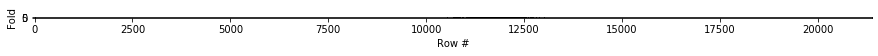

In [26]:
## cross validation
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), features, labels)

''

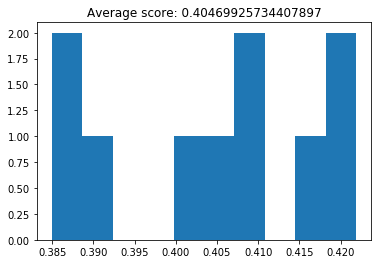

In [25]:
# Now we have a more consistent rating: however is not that good
decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

''

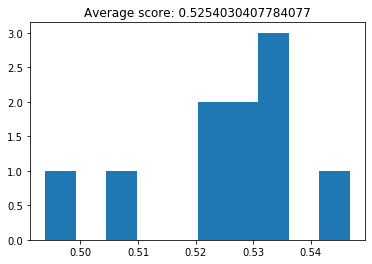

In [7]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

AttributeError: 'DecisionTreeClassifier' object has no attribute 'evaluate'

Text(0.5, 1.0, 'Average score: 0.5254030407784077')

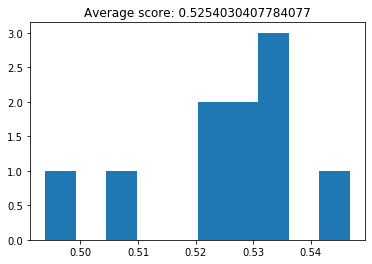

In [44]:
## MINIFIED

    
StratifiedKFold(n_splits=10)

decision_tree_classifier = DecisionTreeClassifier(max_depth=2)

cv_scores = cross_val_score(decision_tree_classifier, features_min, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [27]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(features, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5078132310283522
Best parameters: {'max_depth': 4, 'max_features': 4}


''

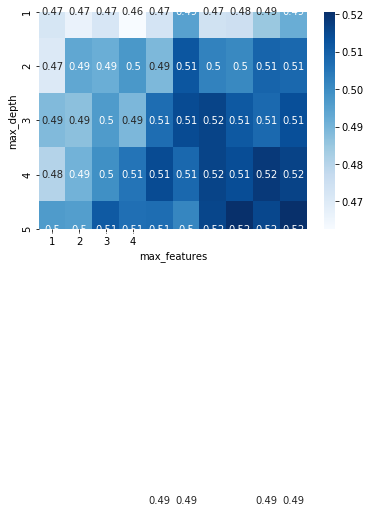

In [41]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (10, 10)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

In [34]:

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(features, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5121643117806681
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 4, 'splitter': 'best'}


In [35]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Text(0.5, 1.0, 'Average score: 0.5204455524590286')

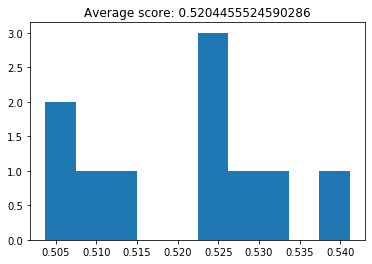

In [46]:
from sklearn.ensemble import RandomForestClassifier

StratifiedKFold(n_splits=10)

random_forest_classifier = RandomForestClassifier(max_depth=4)

cv_scores = cross_val_score(random_forest_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

Best score: 0.5155328904276223
Best parameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 100}


TypeError: '<' not supported between instances of 'GridSearchCV' and 'float'

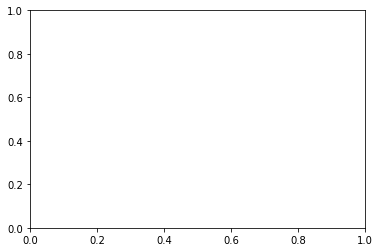

In [47]:

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(features, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

from sklearn import svm


plt.hist(grid_search)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

''

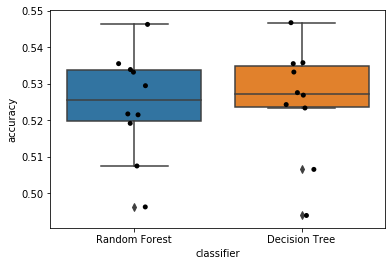

In [21]:
rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, features, labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, features, labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sns.boxplot(x='classifier', y='accuracy', data=both_df)
sns.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

<h3>KNN Algorithm</h3>
<p> K-nearest neighbors with an Euclidean distance measure is sensitive to magnitudes and hence should be scaled for all features to weigh in equally.</p>
<p>The following one is with using 20% of the entries for test and the rest to train</p>

In [4]:
from sklearn.preprocessing import StandardScaler

X1_train, X1_test, Y1_train, Y1_test = train_test_split(features, labels, test_size=0.20)

scaler = StandardScaler()
scaler.fit(X1_train)

X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X1_train, Y1_train)
y1_pred = classifier.predict(X1_test)

y1_pred = classifier.predict(X1_test)

print(confusion_matrix(Y1_test, y1_pred))
print(classification_report(Y1_test, y1_pred))

[[ 580  252  370]
 [ 390  308  422]
 [ 499  403 1051]]
              precision    recall  f1-score   support

           0       0.39      0.48      0.43      1202
           1       0.32      0.28      0.30      1120
           2       0.57      0.54      0.55      1953

    accuracy                           0.45      4275
   macro avg       0.43      0.43      0.43      4275
weighted avg       0.46      0.45      0.45      4275



<h5>Using k-fold cross validation:</h5>

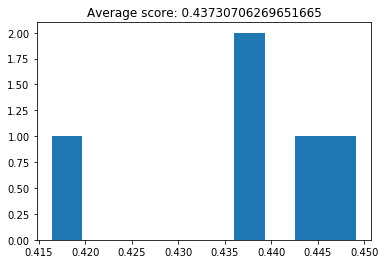

0.48755724017959656

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

knn_cv = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_cv, features, labels, cv=5)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
knn_gscv.fit(features, labels)
#knn_gscv.best_params_
knn_gscv.best_score_


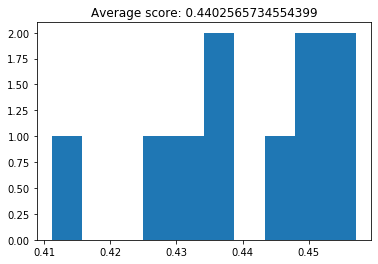

In [14]:
knn_cv = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_cv, features_min, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

<p>Now we should try to find the best parameters</p>

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)


params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'weights': ['uniform', 'distance'],
              'p': [1, 2, 5, 8 , 16]}

grid = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1,
                      scoring='accuracy', 
                      return_train_score=True)


In [ ]:
grid.cv_results_['mean_test_score']

In [51]:
results_KNN = pd.DataFrame(grid.cv_results_['params'])
results_KNN['test_score'] = grid.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
results_KNN

,n_neighbors,p,test_score,metric
0,1,1,0.410989,Manhattan
1,1,2,0.412002,Euclidean
2,1,5,0.398297,Minkowski
3,2,1,0.389807,Manhattan
4,2,2,0.390178,Euclidean
5,2,5,0.369878,Minkowski
6,3,1,0.433062,Manhattan
7,3,2,0.435221,Euclidean
8,3,5,0.423803,Minkowski
9,4,1,0.430396,Manhattan


<h3>We should test different K values</h3>

In [24]:
'''
error_rate = []
for i in range(1,40):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')'''


"\nerror_rate = []\nfor i in range(1,40):\n\n    knn = KNeighborsClassifier(n_neighbors=i)\n    knn.fit(X_train,Y_train)\n    pred_i = knn.predict(X_test)\n    error_rate.append(np.mean(pred_i != Y_test))\n    \nplt.figure(figsize=(12, 6))\nplt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o',\n         markerfacecolor='blue', markersize=10)\nplt.title('Error Rate K Value')\nplt.xlabel('K Value')\nplt.ylabel('Mean Error')"

# Support Vector Machines

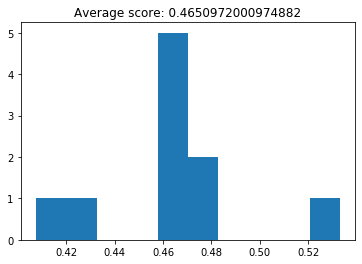

In [15]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

cv_scores = cross_val_score(clf, features_min, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

In [14]:
#Testing
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='micro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='micro'))

Accuracy: 0.445
Precision: 0.445
Recall: 0.445


# Neural Networks

### Building a Custom Model

In [53]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            8, activation="relu", input_shape=(features.shape[-1],)
        ),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(3, activation="softmax"),
    ]
)
model.summary()
Wsave = model.get_weights()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 8)                 256       
_________________________________________________________________
dense_33 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)               

In [48]:
fold = "1"

train_features = pd.read_csv(os.path.join('folds' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1)
train_targets = pd.read_csv(os.path.join('targets' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1)
val_features = pd.read_csv(os.path.join('folds' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1)
val_targets = pd.read_csv(os.path.join('targets' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1)


### Model Training

### Testing

In [43]:
pred_test= model.predict(val_features)
loss, accuracy, f1_score, precision, recall = model.evaluate(val_features, val_targets, verbose=0)
print("Accuracy: %f" % accuracy)
print("Loss: %f" % loss)
print("Precision: %f" % precision)
print("Recall: %f" % recall)
print("F1 Score: %f" % f1_score)

Accuracy: 0.523854
Loss: 1.023597
Precision: 0.747139
Recall: 0.074627
F1 Score: 0.132363


Train on 17098 samples, validate on 4276 samples
Epoch 1/30
17098/17098 [==============================] - 2s 145us/sample - loss: 1.0637 - acc: 0.4530 - f1_m: 0.1451 - precision_m: 0.5017 - recall_m: 0.0886 - val_loss: 1.0605 - val_acc: 0.4588 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
17098/17098 [==============================] - 0s 25us/sample - loss: 1.0508 - acc: 0.4591 - f1_m: 0.2146 - precision_m: 0.5689 - recall_m: 0.1356 - val_loss: 1.0384 - val_acc: 0.4588 - val_f1_m: 0.2052 - val_precision_m: 0.6598 - val_recall_m: 0.1215
Epoch 3/30
17098/17098 [==============================] - 0s 24us/sample - loss: 1.0370 - acc: 0.4827 - f1_m: 0.2768 - precision_m: 0.5886 - recall_m: 0.1860 - val_loss: 1.0510 - val_acc: 0.4944 - val_f1_m: 0.0156 - val_precision_m: 0.7064 - val_recall_m: 0.0079
Epoch 4/30
17098/17098 [==============================] - 0s 24us/sample - loss: 1.0268 - acc: 0.4985 - f1_m: 0.2889 - precision_m: 0.6028 - recall_m

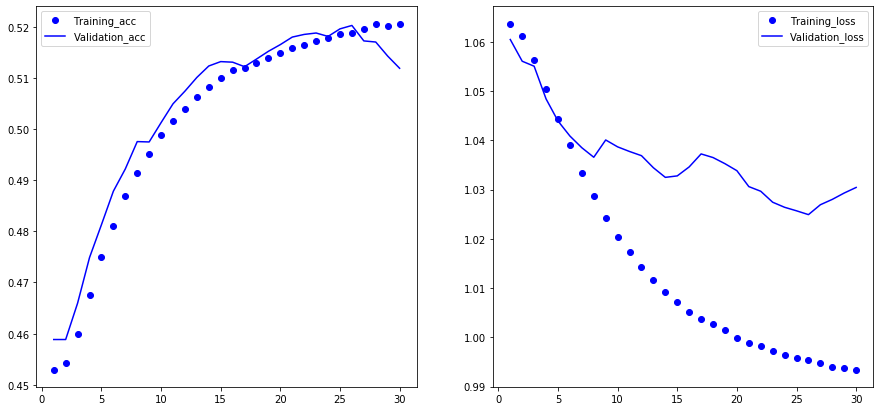

Accuracy: 0.502339
Loss: 1.034958
Precision: 0.556263
Recall: 0.074813
F1 Score: 0.128722


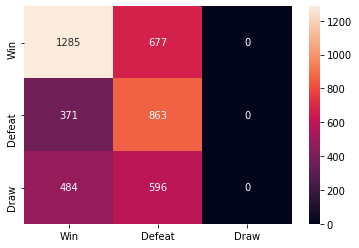

Train on 17099 samples, validate on 4275 samples
Epoch 1/30
17099/17099 [==============================] - 3s 150us/sample - loss: 1.0625 - acc: 0.4533 - f1_m: 0.1533 - precision_m: 0.5127 - recall_m: 0.0948 - val_loss: 1.0621 - val_acc: 0.4589 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
17099/17099 [==============================] - 0s 25us/sample - loss: 1.0464 - acc: 0.4620 - f1_m: 0.2370 - precision_m: 0.5849 - recall_m: 0.1520 - val_loss: 1.0491 - val_acc: 0.4800 - val_f1_m: 0.0842 - val_precision_m: 0.7381 - val_recall_m: 0.0447
Epoch 3/30
17099/17099 [==============================] - 0s 24us/sample - loss: 1.0299 - acc: 0.4916 - f1_m: 0.2905 - precision_m: 0.6054 - recall_m: 0.1947 - val_loss: 1.0466 - val_acc: 0.4770 - val_f1_m: 0.0932 - val_precision_m: 0.6621 - val_recall_m: 0.0502
Epoch 4/30
17099/17099 [==============================] - 0s 25us/sample - loss: 1.0206 - acc: 0.5028 - f1_m: 0.3107 - precision_m: 0.6096 - recall_m

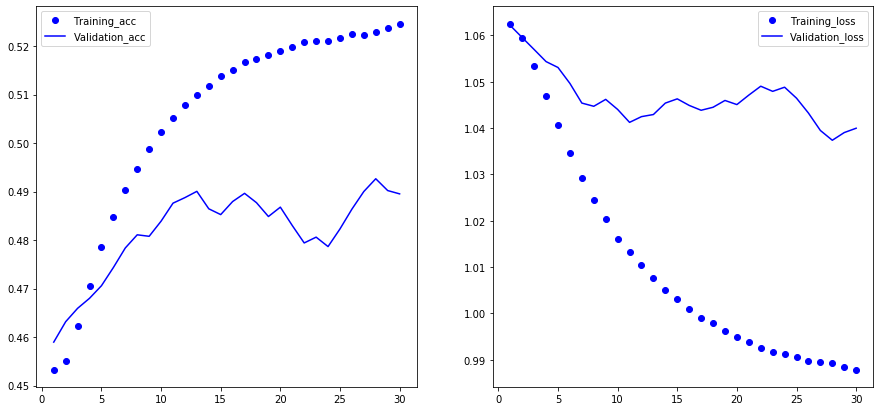

Accuracy: 0.486784
Loss: 1.043709
Precision: 0.596352
Recall: 0.075732
F1 Score: 0.131337


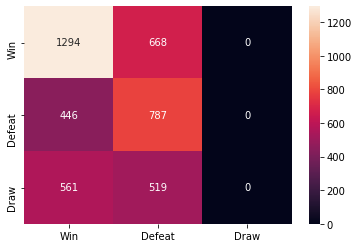

Train on 17099 samples, validate on 4275 samples
Epoch 1/30
17099/17099 [==============================] - 3s 155us/sample - loss: 1.0642 - acc: 0.4527 - f1_m: 0.1451 - precision_m: 0.5113 - recall_m: 0.0895 - val_loss: 1.0575 - val_acc: 0.4589 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
17099/17099 [==============================] - 0s 28us/sample - loss: 1.0494 - acc: 0.4617 - f1_m: 0.2233 - precision_m: 0.5808 - recall_m: 0.1420 - val_loss: 1.0448 - val_acc: 0.5046 - val_f1_m: 0.0529 - val_precision_m: 0.6867 - val_recall_m: 0.0275
Epoch 3/30
17099/17099 [==============================] - 0s 29us/sample - loss: 1.0312 - acc: 0.4946 - f1_m: 0.2865 - precision_m: 0.6068 - recall_m: 0.1916 - val_loss: 1.0308 - val_acc: 0.5146 - val_f1_m: 0.1249 - val_precision_m: 0.7021 - val_recall_m: 0.0686
Epoch 4/30
17099/17099 [==============================] - 0s 29us/sample - loss: 1.0219 - acc: 0.5014 - f1_m: 0.3039 - precision_m: 0.6077 - recall_m

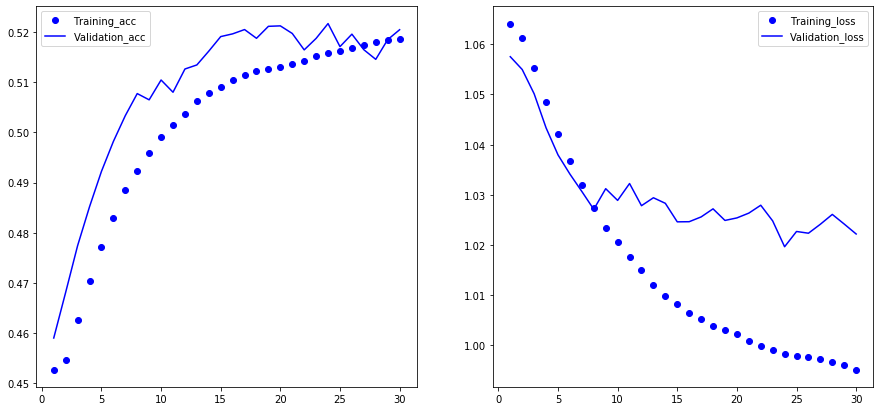

Accuracy: 0.528421
Loss: 1.014223
Precision: 0.702010
Recall: 0.100464
F1 Score: 0.170513


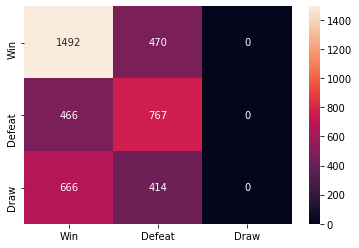

Train on 17100 samples, validate on 4274 samples
Epoch 1/30
17100/17100 [==============================] - 3s 155us/sample - loss: 1.0649 - acc: 0.4516 - f1_m: 0.1407 - precision_m: 0.4999 - recall_m: 0.0860 - val_loss: 1.0680 - val_acc: 0.4591 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
17100/17100 [==============================] - 0s 27us/sample - loss: 1.0516 - acc: 0.4589 - f1_m: 0.2101 - precision_m: 0.5676 - recall_m: 0.1331 - val_loss: 1.0552 - val_acc: 0.4740 - val_f1_m: 3.9024e-04 - val_precision_m: 0.2000 - val_recall_m: 1.9531e-04
Epoch 3/30
17100/17100 [==============================] - 0s 26us/sample - loss: 1.0355 - acc: 0.4828 - f1_m: 0.2756 - precision_m: 0.5907 - recall_m: 0.1828 - val_loss: 1.0481 - val_acc: 0.4939 - val_f1_m: 0.0124 - val_precision_m: 0.7029 - val_recall_m: 0.0063
Epoch 4/30
17100/17100 [==============================] - 0s 26us/sample - loss: 1.0268 - acc: 0.5009 - f1_m: 0.2912 - precision_m: 0.5967 - 

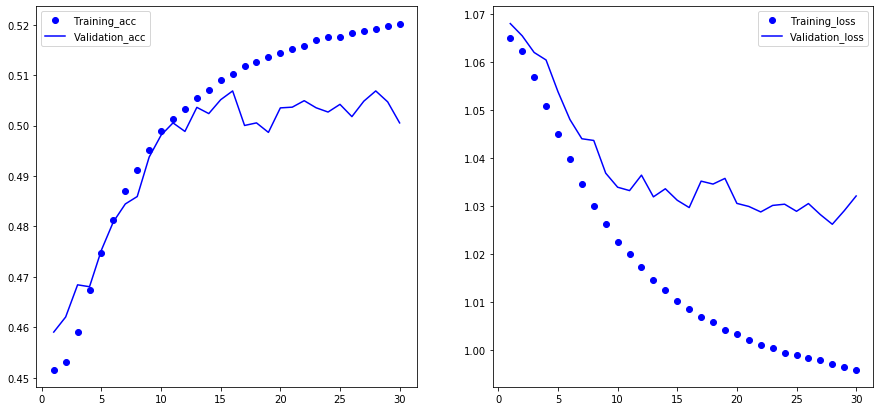

Accuracy: 0.483856
Loss: 1.044419
Precision: 0.509075
Recall: 0.115672
F1 Score: 0.185706


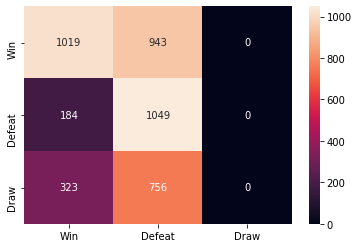

Train on 17100 samples, validate on 4274 samples
Epoch 1/30
17100/17100 [==============================] - 3s 156us/sample - loss: 1.0640 - acc: 0.4518 - f1_m: 0.1431 - precision_m: 0.4955 - recall_m: 0.0889 - val_loss: 1.0587 - val_acc: 0.4591 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
17100/17100 [==============================] - 0s 26us/sample - loss: 1.0447 - acc: 0.4655 - f1_m: 0.2426 - precision_m: 0.5784 - recall_m: 0.1570 - val_loss: 1.0496 - val_acc: 0.5012 - val_f1_m: 0.0358 - val_precision_m: 0.7079 - val_recall_m: 0.0184
Epoch 3/30
17100/17100 [==============================] - 0s 26us/sample - loss: 1.0328 - acc: 0.4991 - f1_m: 0.2846 - precision_m: 0.5966 - recall_m: 0.1913 - val_loss: 1.0496 - val_acc: 0.4946 - val_f1_m: 0.0296 - val_precision_m: 0.8697 - val_recall_m: 0.0151
Epoch 4/30
17100/17100 [==============================] - 0s 27us/sample - loss: 1.0202 - acc: 0.5063 - f1_m: 0.3026 - precision_m: 0.6043 - recall_m

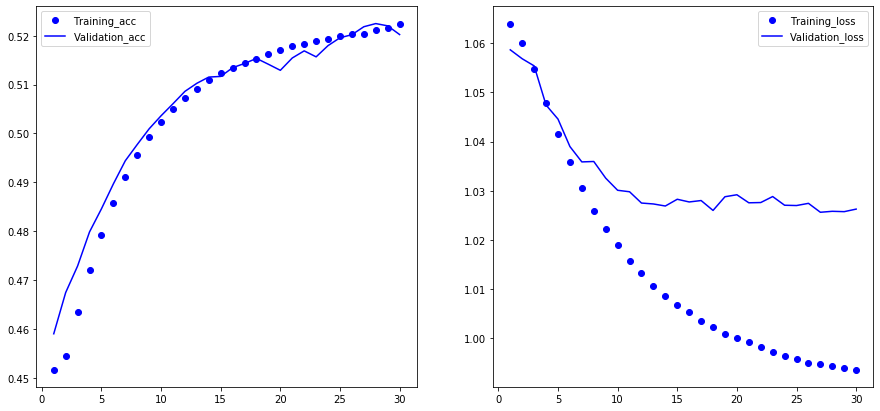

Accuracy: 0.513102
Loss: 1.028340
Precision: 0.555144
Recall: 0.096082
F1 Score: 0.160407


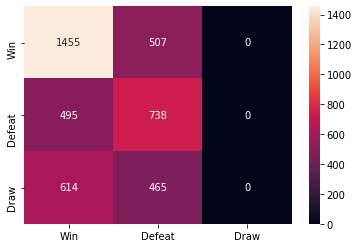

In [65]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def train_and_test_classifier(fold):
    train_features = pd.read_csv(os.path.join('folds' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1)
    train_targets = to_categorical(pd.read_csv(os.path.join('targets' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1))
    val_features = pd.read_csv(os.path.join('folds' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1)
    val_targets = to_categorical(pd.read_csv(os.path.join('targets' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1))


    opt = RMSprop(
        lr=0.001
    )

    model.set_weights(Wsave)
    
    model.compile(
       loss='categorical_crossentropy', optimizer=opt, metrics=['acc',f1_m,precision_m, recall_m]
    )


    history = model.fit(
        train_features,
        train_targets,
        batch_size=1024,
        epochs=30,
        validation_data=(val_features, val_targets),
    )

    # Save weights
    model.save_weights(os.path.join('weights' + os.sep + 'custom', fold + '.h5'))
    
    acc = smooth_curve(history.history['acc'])
    val_acc = smooth_curve(history.history['val_acc'])
    loss = smooth_curve(history.history['loss'])
    val_loss = smooth_curve(history.history['val_loss'])
    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].plot(epochs, acc, 'bo', label='Training_acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation_acc')
    axs[0].legend()
    axs[1].plot(epochs, loss, 'bo', label='Training_loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation_loss')
    axs[1].legend()
    plt.show()
    
    pred_test= model.predict(val_features)
    loss, accuracy, f1_score, precision, recall = model.evaluate(val_features, val_targets, verbose=0)
    print("Accuracy: %f" % accuracy)
    print("Loss: %f" % loss)
    print("Precision: %f" % precision)
    print("Recall: %f" % recall)
    print("F1 Score: %f" % f1_score)
    
    matrix = metrics.confusion_matrix(val_targets.argmax(axis=1), pred_test.argmax(axis=1))
    df_cm = pd.DataFrame(matrix, index = [i for i in ['Win', 'Defeat', 'Draw']],
                  columns = [i for i in ['Win', 'Defeat', 'Draw']])
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    


# Plot history
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



for fold in range(5):
    train_and_test_classifier(str(fold + 1))